# DEEP FAKE DETECTOR


### Packages




In [1]:
# Only if you don't have it installed
# !pip install pathos

import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
import time
from pathos.multiprocessing import ProcessingPool as Pool
from multiprocessing import cpu_count
import json
import random
import sys

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00


In [2]:
# If you are working from Colab

from google.colab import drive
drive.mount('/content/drive')

# This can make faster the training because you are storing the file in local on colab, so you can use the 100% power of the GPU/TPU

!cp -r /content/drive/MyDrive/Colab\ Notebooks/DF-DCT/Processed_data /content/

Mounted at /content/drive


## Data

In [6]:
# Need to determine the values of the files

VIDEO_WIDTH, VIDEO_HEIGHT = 64, 64
MAX_FRAMES = 40  # Number of frames of a video that will be fed to the model as one sequence
BATCH_SIZE = 32

DATASET_DIR = "Video Dataset Small"
PROCESSED_DIR = "/content/Processed_data"
CLASSES = ["fake", "real"]

In [7]:
# Data Loader, iterable object that generates the batch

class VideoDataGenerator(Sequence):
    def __init__(self, data_dir, subset, batch_size=BATCH_SIZE):
        self.data_dir = data_dir
        self.subset = subset
        self.batch_size = batch_size
        self.classes = ['real', 'fake']
        self.videos = self._get_video_paths()
        self.on_epoch_end()

    def _get_video_paths(self):
        videos = []
        subset_dir = os.path.join(self.data_dir, self.subset)
        for class_name in self.classes:
            class_dir = os.path.join(subset_dir, class_name)
            for video_name in os.listdir(class_dir):
                if video_name.endswith('.npy'):
                    videos.append((os.path.join(class_dir, video_name), self.classes.index(class_name)))
        return videos

    def __len__(self):
        return len(self.videos) // self.batch_size

    def __getitem__(self, idx):
        batch_videos = self.videos[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_frames = []
        batch_labels = []

        for video_path, label in batch_videos:
            frames = np.load(video_path)
            batch_frames.append(frames)
            batch_labels.append(label)

        return np.array(batch_frames), np.array(batch_labels)

    def on_epoch_end(self):
        np.random.shuffle(self.videos)


train_generator = VideoDataGenerator(PROCESSED_DIR, "Train")
val_generator = VideoDataGenerator(PROCESSED_DIR, "Val")
test_generator = VideoDataGenerator(PROCESSED_DIR, "Test")

## Creating the model


### CNN

In [15]:
# Here we will add the model that performed the best on the img dataset without the last dense layer

CNN_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(64, (5, 5), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Flatten(),

    layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),

])

### LSTM

In [16]:
CNN_LSTM_model = models.Sequential()

# Input
CNN_LSTM_model.add(layers.Input((MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3))) # 3 are the channels

# Adding the time distributed CNN
CNN_LSTM_model.add(layers.TimeDistributed(CNN_model))

# Creating the LSTM part
CNN_LSTM_model.add(layers.LSTM(64, return_sequences=False))
CNN_LSTM_model.add(layers.Dense(64, activation='relu'))
CNN_LSTM_model.add(layers.Dropout(0.25)) # Dropout layer with 25% rate
CNN_LSTM_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

CNN_LSTM_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

CNN_LSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 40, 256)           466208    
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 64)                82176     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 552609 (2.11 MB)
Trainable params: 552609 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

### Training

In [17]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch')

history = CNN_LSTM_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint_callback])

# Saving the history on a JSON file in order to not loose the results and run everytime the code
with open('history.json', 'w') as f:
    json.dump(history.history, f)

Epoch 1/20
437/437 [==============================] - 105s 234ms/step - loss: 0.6970 - accuracy: 0.5551 - val_loss: 0.6576 - val_accuracy: 0.6297
Epoch 2/20
437/437 [==============================] - 100s 228ms/step - loss: 0.5079 - accuracy: 0.7659 - val_loss: 0.3347 - val_accuracy: 0.8767
Epoch 3/20
437/437 [==============================] - 100s 228ms/step - loss: 0.2888 - accuracy: 0.8902 - val_loss: 0.2072 - val_accuracy: 0.9318
Epoch 4/20
437/437 [==============================] - 99s 227ms/step - loss: 0.1793 - accuracy: 0.9392 - val_loss: 0.1298 - val_accuracy: 0.9597
Epoch 5/20
437/437 [==============================] - 99s 227ms/step - loss: 0.1290 - accuracy: 0.9607 - val_loss: 0.1260 - val_accuracy: 0.9627
Epoch 6/20
437/437 [==============================] - 99s 226ms/step - loss: 0.1039 - accuracy: 0.9710 - val_loss: 0.1190 - val_accuracy: 0.9691
Epoch 7/20
437/437 [==============================] - 99s 227ms/step - loss: 0.0859 - accuracy: 0.9759 - val_loss: 0.0910 - val

## Evaluation

In [55]:
# Loading different epochs to see wich is better
model_path = '/content/model_epoch_18.keras'
CNN_LSTM_model.load_weights(model_path)

# Evaluating the model
test_loss, test_accuracy = CNN_LSTM_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 [==============================] - 6s 66ms/step - loss: 0.0911 - accuracy: 0.9778
Test Loss: 0.09113491326570511
Test Accuracy: 0.9778226017951965


In [53]:
model_path = '/content/model_epoch_20.keras'
CNN_LSTM_model.load_weights(model_path)

# Evaluating the model
test_loss, test_accuracy = CNN_LSTM_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 [==============================] - 6s 67ms/step - loss: 0.0911 - accuracy: 0.9778
Test Loss: 0.09113235771656036
Test Accuracy: 0.9778226017951965


### Classification report

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
for _, labels in test_generator:
    y_true.extend(labels.flatten())
y_true = np.array(y_true)

# Confusion matrix
y_pred = CNN_LSTM_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)


# Classification report
report = classification_report(y_true, y_pred_classes, target_names=CLASSES)
print("Classification Report:")
print(report)



93/93 [==============================] - 6s 63ms/step
Confusion Matrix:
[[1439   46]
 [  19 1472]]
Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.97      0.98      1485
        real       0.97      0.99      0.98      1491

    accuracy                           0.98      2976
   macro avg       0.98      0.98      0.98      2976
weighted avg       0.98      0.98      0.98      2976



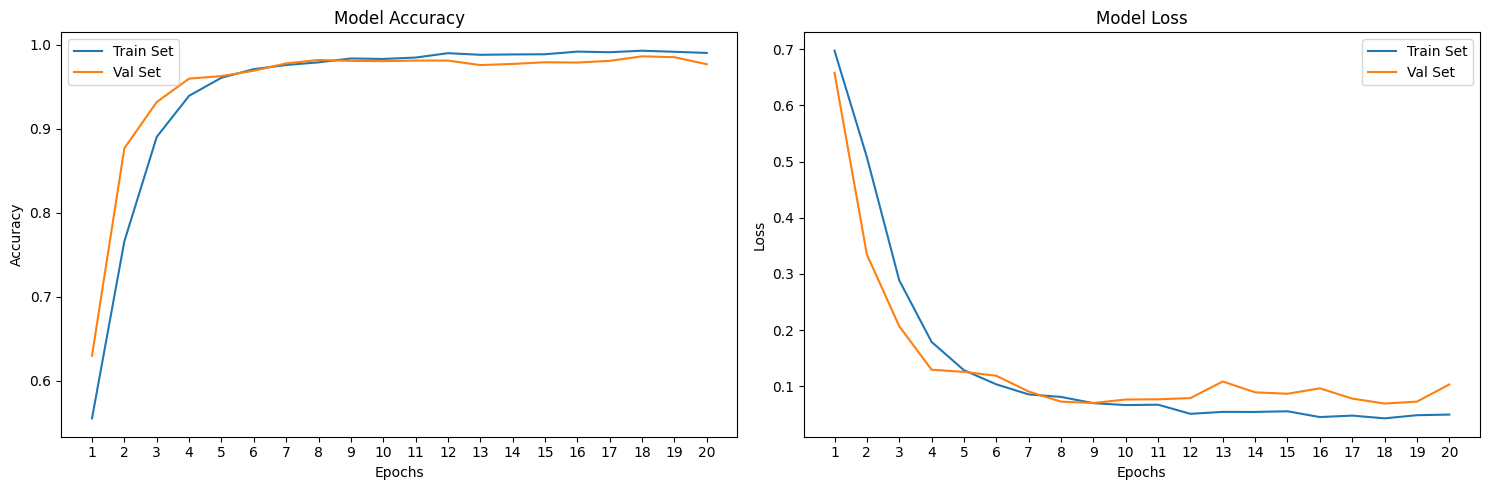

In [39]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting accuracy
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Set')
plt.plot(epochs, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])


# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Set')
plt.plot(epochs, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.xticks(ticks=range(1, len(epochs) + 1),
           labels=[str(int(round(x))) for x in range(1, len(epochs) + 1)])

plt.tight_layout()
plt.show()